G05: Winkler, Jakober, Matzinger, Salzmann

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# from torchinfo import summary
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


# Many to One Approach

### Load data

In [3]:
file_path = '../data/companies.csv'

with open(file_path) as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
    
print(f"Loaded a corpus of {corpus_length} characters")

Loaded a corpus of 2567986 characters


### Preprocess data

In [4]:
def create_encoding(corpus):
    chars = sorted(list(set(corpus)))
    num_chars = len(chars)
    encoding = {c: i for i, c in enumerate(chars)}
    decoding = {i: c for i, c in enumerate(chars)}
    # print(f'Our corpus contains {num_chars} unique characters.')
    return num_chars, encoding, decoding

In [5]:
def create_dataset(corpus, encoding, seq_length, skip):
    X_data = []
    y_data = []

    for i in range(0, len(corpus) - seq_length, skip):
        sentence = corpus[i:i+seq_length]
        next_char = corpus[i+seq_length]
        X_data.append([encoding[char] for char in sentence])
        y_data.append(encoding[next_char])

    # print(f'Sliced our corpus into {num_sentences} sentences of length {seq_length}')
    return X_data, y_data

In [6]:
def create_onehot(X_data, y_data, num_chars):
    X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float32)
    y = torch.tensor(y_data)
    dataset = TensorDataset(X, y)
    return dataset, X, y

In [7]:
num_chars, encoding, decoding = create_encoding(corpus)
print(encoding)
print(decoding)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, '=': 28, '>': 29, '?': 30, '@': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, '\\': 59, ']': 60, '^': 61, '_': 62, 'a': 63, 'b': 64, 'c': 65, 'd': 66, 'e': 67, 'f': 68, 'g': 69, 'h': 70, 'i': 71, 'j': 72, 'k': 73, 'l': 74, 'm': 75, 'n': 76, 'o': 77, 'p': 78, 'q': 79, 'r': 80, 's': 81, 't': 82, 'u': 83, 'v': 84, 'w': 85, 'x': 86, 'y': 87, 'z': 88, '{': 89, '|': 90, '}': 91, '~': 92, '\x81': 93, '\x82': 94, '\x83': 95, '\x84': 96, '\x85': 97, '\x86': 98, '\x87': 99, '\x88': 100, '\x89': 101, '\x8a': 102, '\x8b': 103, '\x8c': 104, '\x8d': 105, '\x8e': 

In [8]:
seq_length = 10
skip = 3

X_data, y_data = create_dataset(corpus, encoding, seq_length, skip)

print(X_data[0])
print([decoding[idx] for idx in X_data[0]])
print(decoding[y_data[0]])

[39, 63, 81, 70, 78, 74, 63, 87, 1, 40]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
n


In [9]:
dataset, X, y = create_onehot(X_data, y_data, num_chars)

print(f'Sanity check for X:\n\
    Dimension: {X.shape}\n\
    Sentence length: {seq_length}')
print(f'Sanity check for y:\n\
    Dimension: {y.shape}\n\
    # Sentences: {len(X_data)}\n\
    Characters in corpus: {num_chars}')

Sanity check for X:
    Dimension: torch.Size([855992, 10, 150])
    Sentence length: 10
Sanity check for y:
    Dimension: torch.Size([855992])
    # Sentences: 855992
    Characters in corpus: 150


In [10]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Train Loop

In [34]:
def train(model, dataloader, optimizer, criterion, n_epochs, log_interval=200):
    
    total_batches = n_epochs * len(dataloader)
    progress = tqdm(total=total_batches, desc='Training Progress', leave=True)

    train_losses = []
    train_accs = []

    for epoch in range(n_epochs):
        train_loss = 0
        train_correct = 0
        train_total = 0

        model.train()
        for X_train, y_train in dataloader: #tqdm(dataloader, desc=f'Training Epoch: {epoch+1}'):
            X_train, y_train = X_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, y_pred = torch.max(output, dim=1)
            train_correct += (y_pred == y_train).sum().item()
            train_total += y_train.size(0)

            progress.update(1)
        
        avg_train_loss = train_loss / len(dataloader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

    return {
        'loss': train_losses,
        'accuracy': train_accs
    }

In [12]:
@torch.inference_mode()
def predict(model, x):
    model.eval()
    with torch.no_grad():
        return model(x)

In [13]:
def plot_loss_curve(n_epochs, train_losses, train_acc, title):
    
    fig, ax = plt.subplots(1, 2, figsize=(18,6), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()
    
    fig.suptitle(title)
    plt.show()

### Text generation

In [14]:
def set_seed(seed_phrase=''):
    if seed_phrase:
        seed_length = len(seed_phrase)
        pattern = ''
        for i in range(0, seq_length):
            pattern += seed_phrase[i % seed_length]
    else:
        seed = random.randint(0, corpus_length - seq_length)
        pattern = corpus[seed:seed+seq_length]
    print(f'Seed: {pattern}')
    return pattern

def encode(encoding, seed_pattern, num_chars):
    encoded_text = torch.tensor([encoding[char] for char in seed_pattern])
    encoded_text = F.one_hot(encoded_text, num_classes=num_chars).to(torch.float32)
    encoded_text = encoded_text.unsqueeze(0) # Single batch
    return encoded_text.to(device)

def generate(model, encoded_text, decoding, num_chars, length):
    generated_text = ''
    for i in range(length):
        output = predict(model, encoded_text)[0]
        logits = torch.softmax(output, dim=-1)
        y_pred = torch.multinomial(logits, num_samples=1)
        generated_text += decoding[int(y_pred)]

        next_char_encoded = F.one_hot(y_pred, num_classes=num_chars)
        next_char_encoded = next_char_encoded.view(1, 1, num_chars)
        encoded_text = torch.cat((encoded_text[:, 1:], next_char_encoded), dim=1)
    print(f'Suggested names:\n{generated_text}')

### Model Class

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1])

In [16]:
model = RNN(input_size=num_chars, hidden_size=256, num_layers=1, num_classes=num_chars)
summary(model, input_size=(batch_size, seq_length, num_chars))

Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               104,448
├─Linear: 1-2                            38,550
Total params: 142,998
Trainable params: 142,998
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               104,448
├─Linear: 1-2                            38,550
Total params: 142,998
Trainable params: 142,998
Non-trainable params: 0

### Training Model

In [17]:
results = {}

In [ ]:
n_epochs = 10
hidden_size = 256
num_layers = 1

model = RNN(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_chars).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

results = train(model, dataloader, optimizer, criterion, n_epochs)
plot_loss_curve(n_epochs, results.get('loss'), results.get('accuracy'), 'RNN')

In [ ]:
seed_pattern = set_seed('Cool')
encoded_text = encode(encoding, seed_pattern, num_chars)
generate(model, encoded_text, decoding, num_chars, 50)

In [ ]:
params = {
    'n_epochs': [5, 10, 15],
    'num_layers': [1, 2],
    'hidden_size': [32, 64, 128]
}

for _ in range(5):
    n_epochs = random.choice(params.get('n_epochs'))
    num_layers = random.choice(params.get('num_layers'))
    hidden_size = random.choice(params.get('hidden_size'))

    model = RNN(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_chars).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    results = train(model, dataloader, optimizer, criterion, n_epochs)
    plot_loss_curve(n_epochs, results.get('loss'), results.get('accuracy'), f'n_epochs: {n_epochs}, num_layers: {num_layers}, hidden_size: {hidden_size}')

    seed_pattern = set_seed('Cool')
    encoded_text = encode(encoding, seed_pattern, num_chars)
    generate(model, encoded_text, decoding, num_chars, 32)

### Findings

...

### LSTM

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

In [20]:
n_epochs = 5
num_layers = 1
hidden_size = 128

model = LSTM(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_chars).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

results = train(model, dataloader, optimizer, criterion, n_epochs)
plot_loss_curve(n_epochs, results.get('loss'), results.get('accuracy'), f'n_epochs: {n_epochs}, num_layers: {num_layers}, hidden_size: {hidden_size}')

seed_pattern = set_seed('Cool')
encoded_text = encode(encoding, seed_pattern, num_chars)
generate(model, encoded_text, decoding, num_chars, 32)

Training Epoch: 1:   0%|          | 0/6688 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Dog Names

In [21]:
import requests
import pandas as pd

url = "https://data.cityofnewyork.us/resource/nu7n-tubp.json"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    print(df.head())
else:
    print("Failed to fetch data:", response.status_code)

  animalname animalgender animalbirth                             breedname  \
0      PAIGE            F        2014  American Pit Bull Mix / Pit Bull Mix   
1       YOGI            M        2010                                 Boxer   
2        ALI            M        2014                               Basenji   
3      QUEEN            F        2013                      Akita Crossbreed   
4       LOLA            F        2009                               Maltese   

  zipcode        licenseissueddate       licenseexpireddate extract_year  
0   10035  2014-09-12T00:00:00.000  2017-09-12T00:00:00.000         2016  
1   10465  2014-09-12T00:00:00.000  2017-10-02T00:00:00.000         2016  
2   10013  2014-09-12T00:00:00.000  2019-09-12T00:00:00.000         2016  
3   10013  2014-09-12T00:00:00.000  2017-09-12T00:00:00.000         2016  
4   10028  2014-09-12T00:00:00.000  2017-10-09T00:00:00.000         2016  


In [ ]:
dog_corpus = df['animalname'].dropna().str.title().str.cat(sep='\n')
num_chars, encoding, decoding = create_encoding(dog_corpus)

seq_length, skip = 10, 3
X_data, y_data = create_dataset(dog_corpus, encoding, seq_length, skip)

dataset, X, y = create_onehot(X_data, y_data, num_chars)

Training Progress:   0%|          | 0/850 [00:00<?, ?it/s]

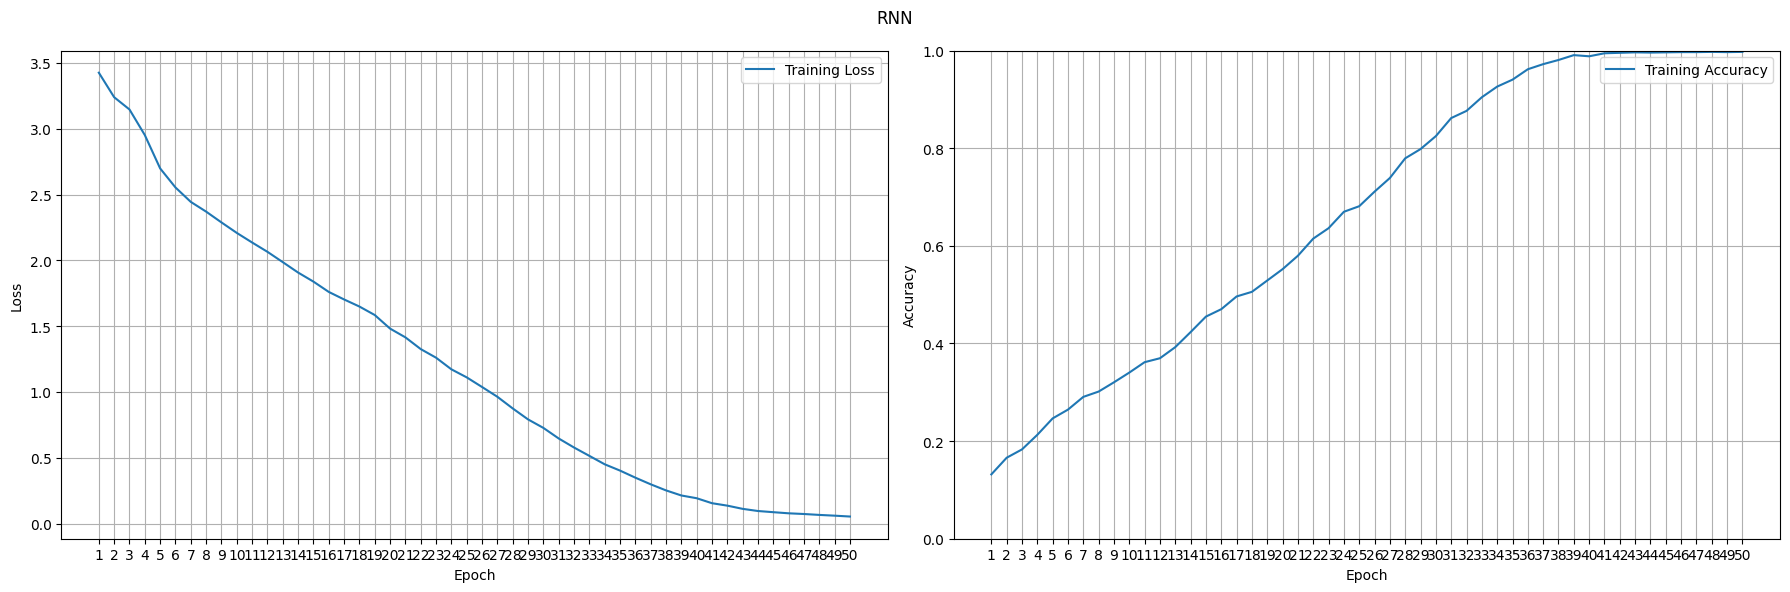

In [35]:
batch_size = 128
hidden_size = 256
num_layers = 2
n_epochs = 50

dataloader = DataLoader(dataset, batch_size, shuffle=True)
model = RNN(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_chars).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

results = train(model, dataloader, optimizer, criterion, n_epochs)
plot_loss_curve(n_epochs, results.get('loss'), results.get('accuracy'), 'RNN')

In [37]:
seed_pattern = set_seed('Mr. Weener')
encoded_text = encode(encoding, seed_pattern, num_chars)
generate(model, encoded_text, decoding, num_chars, 32)

Seed: Mr. Weener
Suggested names:
n
Caxohlosa
Saxper
Tus
Loeiv
Os



Training Progress:   0%|          | 0/850 [00:00<?, ?it/s]

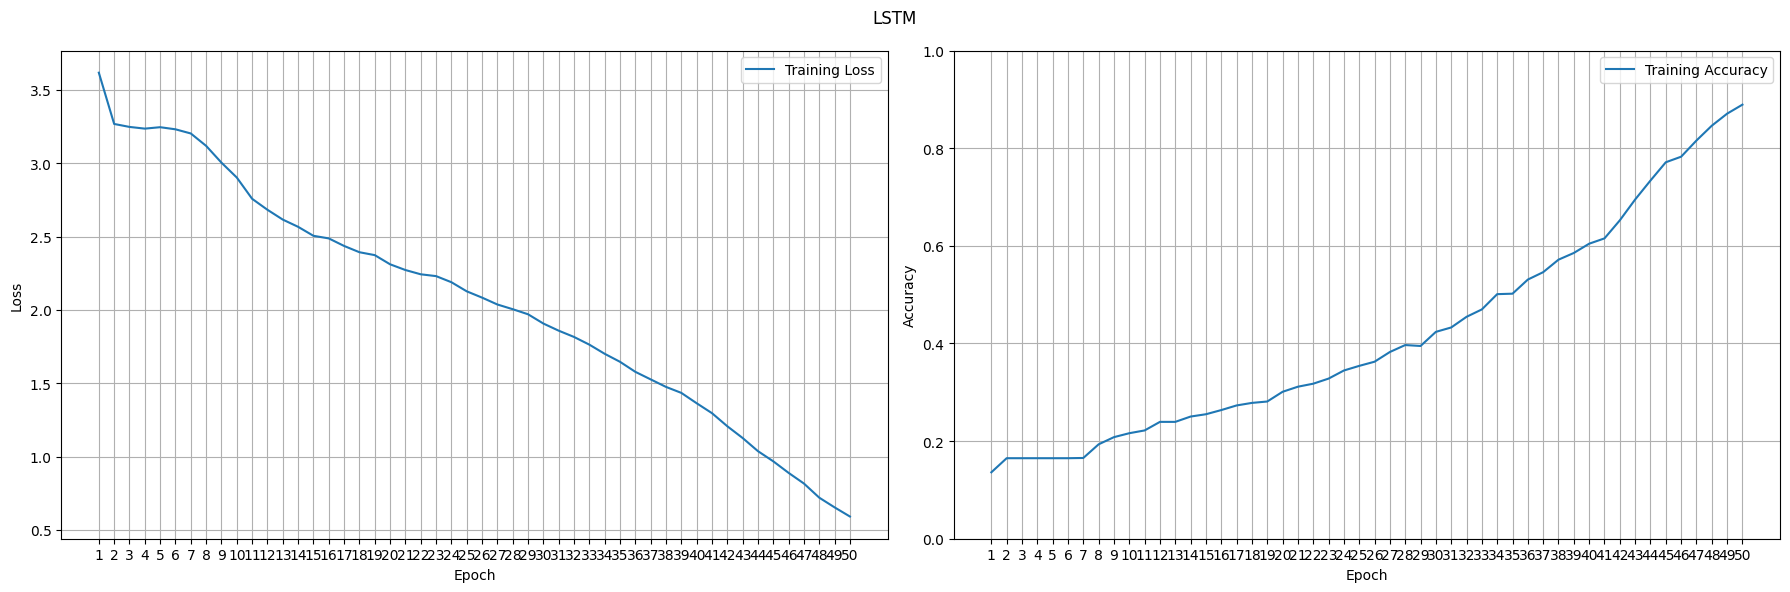

In [38]:
batch_size = 128
hidden_size = 256
num_layers = 2
n_epochs = 50

dataloader = DataLoader(dataset, batch_size, shuffle=True)
model = LSTM(input_size=num_chars, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_chars).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

results = train(model, dataloader, optimizer, criterion, n_epochs)
plot_loss_curve(n_epochs, results.get('loss'), results.get('accuracy'), 'LSTM')

In [39]:
seed_pattern = set_seed('Mr. Weener')
encoded_text = encode(encoding, seed_pattern, num_chars)
generate(model, encoded_text, decoding, num_chars, 32)

Seed: Mr. Weener
Suggested names:
ttit
Srbay
Muk
Wuely
Rowoer
Psrr
